# Initialization and reproductibility

In [2]:
library(rattle)
library(caret)
library(rpart)
library(rpart.plot)
library(corrplot)
library(randomForest)
library(RColorBrewer)
library(party)

In [3]:
set.seed(135)
setwd("~/Practical-Machine-Learning-Johns-Hopkins-Bloomberg-School-of-Public-Health-Coursera")

# Getting Data

In [4]:
trainFile = "./data/pml-training.csv"
testFile  = "./data/pml-testing.csv"


In [5]:
trainRaw = read.csv(trainFile)
testRaw = read.csv(testFile)
dim(trainRaw)
dim(testRaw)
rm(trainFile)
rm(testFile)

[1] 19622   160

[1]  20 160

It should returns

19622 160
20 160

# Data Cleaning

In [6]:
nZv = nearZeroVar(trainRaw, saveMetrics = TRUE)
head(nZv, 20)

,freqRatio,percentUnique,zeroVar,nzv
X,1.000000,100.00000000,FALSE,FALSE
user_name,1.100679,0.03057792,FALSE,FALSE
raw_timestamp_part_1,1.000000,4.26562022,FALSE,FALSE
raw_timestamp_part_2,1.000000,85.53154622,FALSE,FALSE
cvtd_timestamp,1.000668,0.10192641,FALSE,FALSE
new_window,47.330049,0.01019264,FALSE,TRUE
num_window,1.000000,4.37264295,FALSE,FALSE
roll_belt,1.101904,6.77810621,FALSE,FALSE
pitch_belt,1.036082,9.37722964,FALSE,FALSE
yaw_belt,1.058480,9.97349913,FALSE,FALSE


We use the function nearZeroVar in order to use only predictors that is useful for us as a variable with variance near to zero cannot permit to discriminate the factors lead to the output. 

In [7]:
training1 =  trainRaw[, !nZv$nzv]
testing1 = testRaw[, !nZv$nzv]
dim(training1)
dim(testing1)

[1] 19622   100

[1]  20 100

It should return

19622 100

20 100

In [8]:
trainingB = training1[, !grepl("^X|timestamp|user_name", names(training1))]
testing = testing1[, !grepl("^X|timestamp|user_name", names(training1))]


We remove those three variable as it does not provide informations to accelerometer measurements

In [9]:
dim(trainingB)
dim(testing)

[1] 19622    95

[1] 20 95

We should have 

19622 95

20 95

In [10]:
condition=(colSums(is.na(trainingB)) == 0)
trainingB = trainingB[, condition]
testing = testing[, condition]
dim(trainingB)
dim(testing)

[1] 19622    54

[1] 20 54

We removed any columns that contain NA to avoid any problems withour algorithms.
Now we have a cleaned training data set with 19622 datas and 54 variables and testing data set with 20 observations and 54 variables.

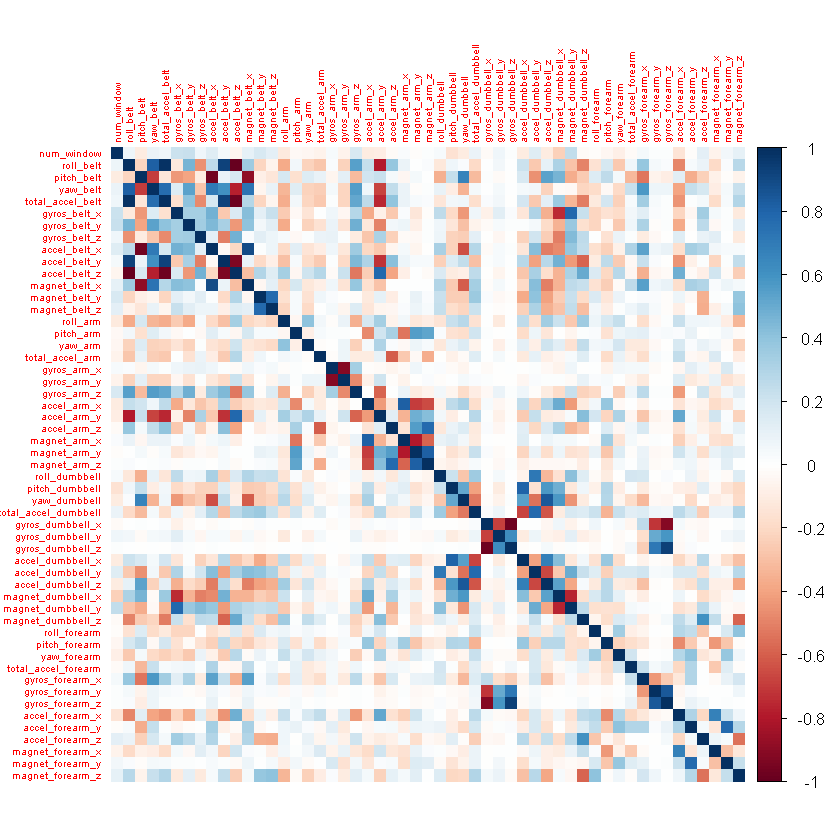

In [10]:
corrplot(cor(trainingB[, -length(names(trainingB))]), method = "color", tl.cex = 0.5)


# Step to Cross validations : Partitioning Training Set

In [11]:
inTrain <- createDataPartition(trainingB$classe, p = 0.70, list = FALSE)

training <- trainingB[inTrain, ]
validation <- trainingB[-inTrain, ]
dim(training)
dim(validation)
dim(testing)

[1] 13737    54

[1] 5885   54

[1] 20 54

We use the carret function : createDataPartition in order to split our training data set to have 70% of training and 30% of validation (optimal farction according to course). We use this validation to have a cross validation.

Now we have a training data set with 13737 observations, a validation with 5885 and a testing with 20 observations.

# Predictive models

## Decision Tree

In [12]:
modFit = train(classe ~ ., method = "rpart", data = training,
                       trControl=trainControl(method="none"),
                       tuneGrid=data.frame(cp=0.001))

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1626   18    9    8   13
         B   49  985   61   23   21
         C    3   28  928   51   16
         D   13   15   54  856   26
         E    2   35   18   56  971

Overall Statistics
                                          
               Accuracy : 0.9118          
                 95% CI : (0.9043, 0.9189)
    No Information Rate : 0.2877          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8884          
                                          
 Mcnemar's Test P-Value : 2.898e-08       

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9604   0.9112   0.8673   0.8612   0.9274
Specificity            0.9885   0.9679   0.9796   0.9779   0.9771
Pos Pred Value         0.9713   0.8648   0.9045   0.8880   0.8974
Neg Pred Value         0.9841   0.979

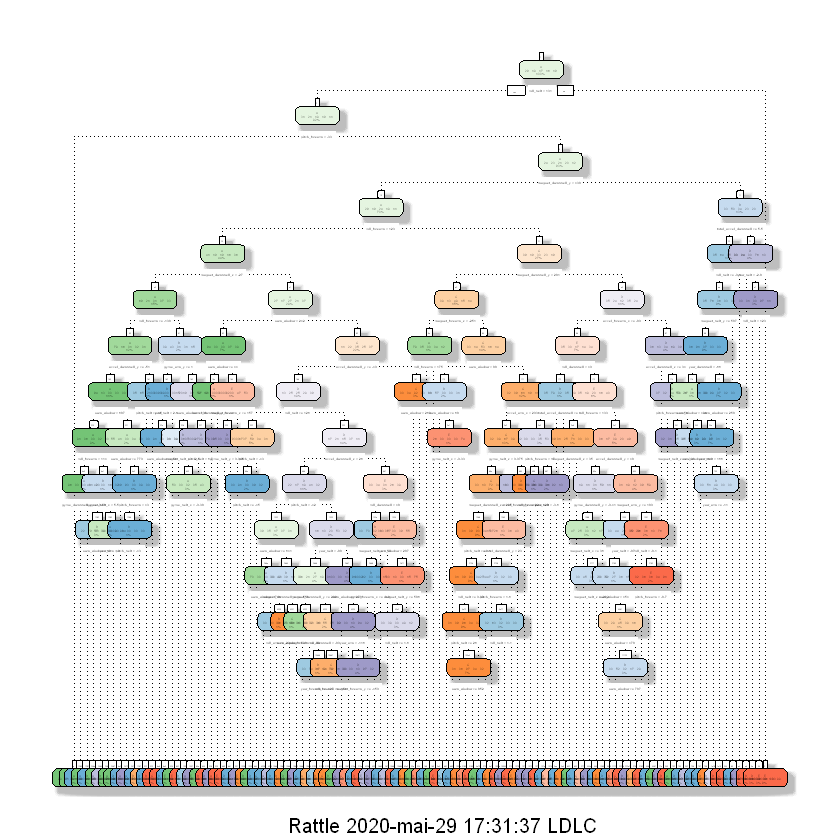

In [13]:
fancyRpartPlot(modFit$finalModel)
predictTree = predict(modFit, validation, type = "raw")
confusionMatrix(validation$classe, predictTree)


Even with fancyrpartplot we can't see the tree but, we can see that there are a lot of seeds which can lead to an overfitting.

Yet, with the conffusion matrix on prediction on validation we have an accuracy of 91% which is raher good.

In [14]:
print(postResample(predictTree, validation$classe))

 Accuracy     Kappa 
0.9118097 0.8884431 


<font color='red'>We have an accuracy of 0.91 with the tree modelling </font>

## Random Forest

We use a predictive model for activity recognition using Random Forest as it selects important variables.
We will use 5-fold cross validation when applying the algorithm.

In [15]:
modelFitRandom <- train(classe ~ ., data = training, method = "rf", trControl = trainControl(method = "cv", 5), ntree = 10)


We have a better accuracy than decision tree as expected

In [17]:
modelFitRandom

Random Forest 

13737 samples
   53 predictor
    5 classes: 'A', 'B', 'C', 'D', 'E' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 10990, 10989, 10990, 10989, 10990 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9805634  0.9754097
  27    0.9928658  0.9909763
  53    0.9879888  0.9848072

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 27.

In [18]:
predictRF = predict(modelFitRandom, validation)
confusionMatrix(validation$classe, predictRF)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1672    2    0    0    0
         B    8 1126    5    0    0
         C    0    8 1016    2    0
         D    0    0    7  957    0
         E    0    2    0    5 1075

Overall Statistics
                                         
               Accuracy : 0.9934         
                 95% CI : (0.991, 0.9953)
    No Information Rate : 0.2855         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9916         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9952   0.9895   0.9883   0.9927   1.0000
Specificity            0.9995   0.9973   0.9979   0.9986   0.9985
Pos Pred Value         0.9988   0.9886   0.9903   0.9927   0.9935
Neg Pred Value         0.9981   0.9975   0.997

In [19]:
print(postResample(predictRF, validation$classe))

 Accuracy     Kappa 
0.9933730 0.9916167 


<font color='red'>We have an accuracy of 0.99 which is better than decision tree as expected</font>

# Predicting for Test Data Set

In [22]:
predict(modelFitRandom, testing[, -length(names(testing))])

[1] B A B A A E D B A A B C B A E E A B B B
Levels: A B C D E